## A. KEGIATAN 1 – KLASIFIKASI CITRA (Transfer Learning CNN)



In [1]:
# 1. Impor semua library
!pip install -q tensorflow==2.15.0

import os, zipfile, shutil, random, glob
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("TensorFlow:", tf.__version__)


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
TensorFlow: 2.19.0


In [2]:
import os, zipfile

# 2–3. Deteksi & ekstrak dataset citra

ZIP_PATH     = "/content/citra.zip"
EXTRACT_DIR  = "/content/citra_raw"

SOURCE_DIR = None

if os.path.isdir(ZIP_PATH):

    SOURCE_DIR = ZIP_PATH
    print("citra.zip terdeteksi sebagai FOLDER, lewati proses ekstrak ZIP.")
else:
    try:
        with zipfile.ZipFile(ZIP_PATH, "r") as zf:
            zf.extractall(EXTRACT_DIR)
        print("Berhasil ekstrak ke:", EXTRACT_DIR)


        subdirs = [d for d in os.listdir(EXTRACT_DIR)
                   if os.path.isdir(os.path.join(EXTRACT_DIR, d))]
        if len(subdirs) == 1:
            SOURCE_DIR = os.path.join(EXTRACT_DIR, subdirs[0])
        else:

            SOURCE_DIR = EXTRACT_DIR

        print("SOURCE_DIR diset ke:", SOURCE_DIR)

    except zipfile.BadZipFile:


        SOURCE_DIR = "/content/citra"


BASE_SPLIT_DIR = "/content/citra_split"
TRAIN_DIR      = os.path.join(BASE_SPLIT_DIR, "train")
VAL_DIR        = os.path.join(BASE_SPLIT_DIR, "val")
TEST_DIR       = os.path.join(BASE_SPLIT_DIR, "test")

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

classes = [d for d in os.listdir(SOURCE_DIR)
           if os.path.isdir(os.path.join(SOURCE_DIR, d))]
print("Kelas ditemukan:", classes)


Berhasil ekstrak ke: /content/citra_raw
SOURCE_DIR diset ke: /content/citra_raw/PetImages
Kelas ditemukan: ['Cat', 'Dog']


In [3]:
# 4. Bagi dataset ke dalam folder train, val, test (70%, 15%, 15%)

for cls in classes:
    src_cls_dir = os.path.join(SOURCE_DIR, cls)
    images = [f for f in os.listdir(src_cls_dir)
              if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    train_files, temp_files = train_test_split(
        images, test_size=0.3, random_state=42
    )
    val_files, test_files = train_test_split(
        temp_files, test_size=0.5, random_state=42
    )

    for split_name, file_list in zip(
        ["train", "val", "test"],
        [train_files, val_files, test_files]
    ):
        dst_cls_dir = os.path.join(BASE_SPLIT_DIR, split_name, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)
        for fname in file_list:
            shutil.copy2(
                os.path.join(src_cls_dir, fname),
                os.path.join(dst_cls_dir, fname)
            )

print("Selesai split dataset.")


Selesai split dataset.


Train: {'Cat': 8749, 'Dog': 8749}
Val  : {'Cat': 1875, 'Dog': 1875}
Test : {'Cat': 1875, 'Dog': 1875}


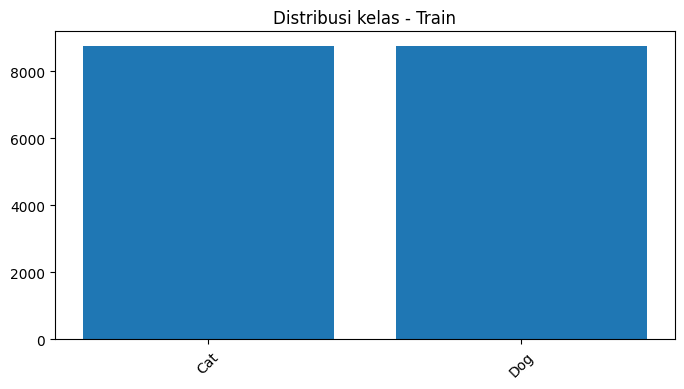

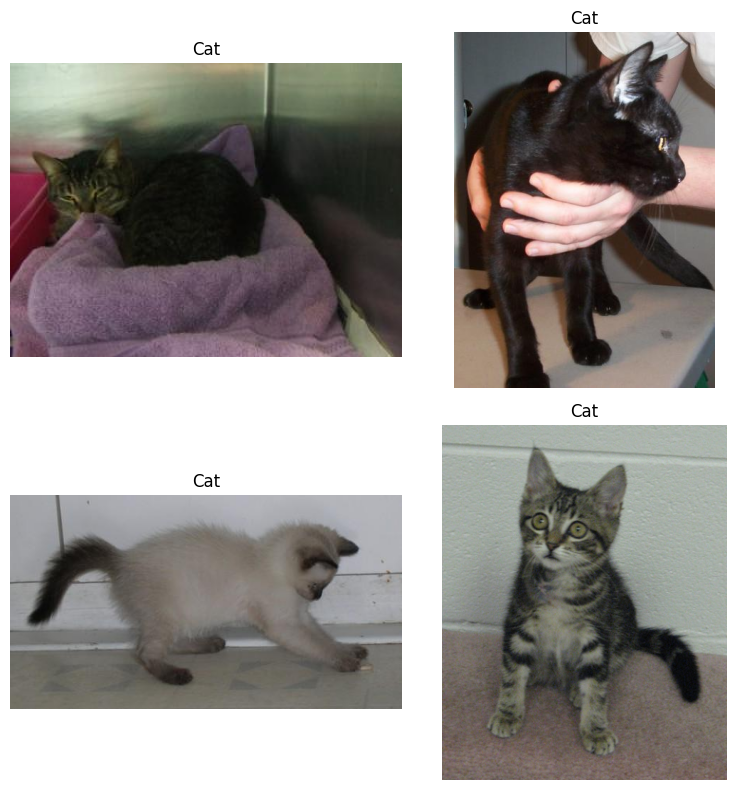

In [4]:
import matplotlib.pyplot as plt

# 5. EDA – distribusi kelas & contoh gambar

def count_images(base_dir):
    counts = {}
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        if os.path.exists(cls_dir):
            counts[cls] = len([
                f for f in os.listdir(cls_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ])
        else:
            counts[cls] = 0
    return counts

train_counts = count_images(TRAIN_DIR)
val_counts   = count_images(VAL_DIR)
test_counts  = count_images(TEST_DIR)

print("Train:", train_counts)
print("Val  :", val_counts)
print("Test :", test_counts)

plt.figure(figsize=(8,4))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Distribusi kelas - Train")
plt.xticks(rotation=45)
plt.show()

# contoh beberapa gambar
sample_cls = classes[0]
sample_dir = os.path.join(TRAIN_DIR, sample_cls)
sample_files = os.listdir(sample_dir)[:4]

plt.figure(figsize=(8,8))
for i, fname in enumerate(sample_files):
    img = load_img(os.path.join(sample_dir, fname))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(sample_cls)
plt.tight_layout()
plt.show()

In [5]:
# 6. Pre-processing & Data Augmentation

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_indices = train_gen.class_indices
idx_to_class  = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)


Found 17498 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Class indices: {'Cat': 0, 'Dog': 1}


In [6]:
# 7. Model transfer learning (MobileNetV2)
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# 8. Pelatihan model
EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)
# 9. Fungsi save model (simple, aman untuk Streamlit)
import os

def save_model_simple(model, filename="model_citra.keras"):
    os.makedirs("models", exist_ok=True)
    path = os.path.join("models", filename)
    model.save(path)
    print("Model berhasil disimpan di:", path)

# panggil fungsi
save_model_simple(model)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


547/547 ━━━━━━━━━━━━━━━━━━━━ 282s 480ms/step - accuracy: 0.9306 - loss: 0.1632 - val_accuracy: 0.9805 - val_loss: 0.0538
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 238s 434ms/step - accuracy: 0.9669 - loss: 0.0931 - val_accuracy: 0.9776 - val_loss: 0.0585
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 235s 429ms/step - accuracy: 0.9714 - loss: 0.0721 - val_accuracy: 0.9803 - val_loss: 0.0520
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 237s 433ms/step - accuracy: 0.9722 - loss: 0.0745 - val_accuracy: 0.9773 - val_loss: 0.0643
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 231s 423ms/step - accuracy: 0.9726 - loss: 0.0694 - val_accuracy: 0.9808 - val_loss: 0.0541
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 238s 435ms/step - accuracy: 0.9717 - loss: 0.0824 - val_accuracy: 0.9816 - val_loss: 0.0503
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 235s 429ms/step - accuracy: 0.9734 - loss: 0.0717 - val_accuracy: 0.9803 - val_loss: 0.0516
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 233s 426ms/step - accuracy: 0.9737 - loss: 0.07

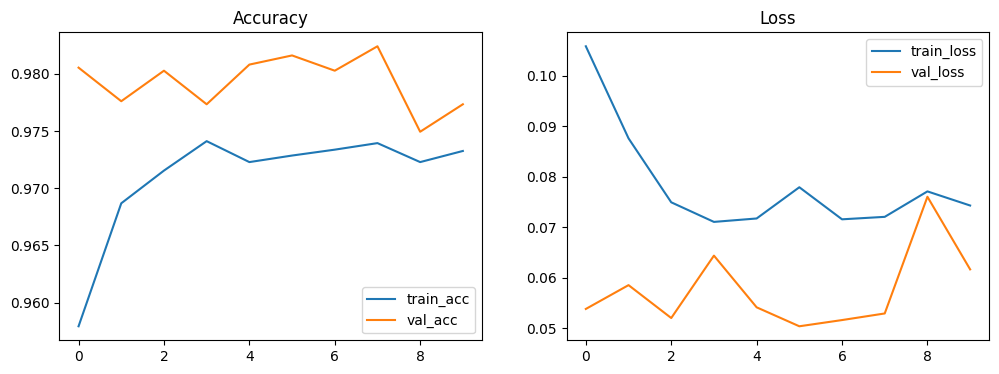

118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step
              precision    recall  f1-score   support

         Cat       0.99      0.97      0.98      1875
         Dog       0.97      0.99      0.98      1875

    accuracy                           0.98      3750
   macro avg       0.98      0.98      0.98      3750
weighted avg       0.98      0.98      0.98      3750



In [7]:
# 9. Evaluasi kinerja model

# Plot akurasi & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.show()

# Evaluasi di data test
test_gen.reset()
y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

target_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print(classification_report(y_true, y_pred, target_names=target_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


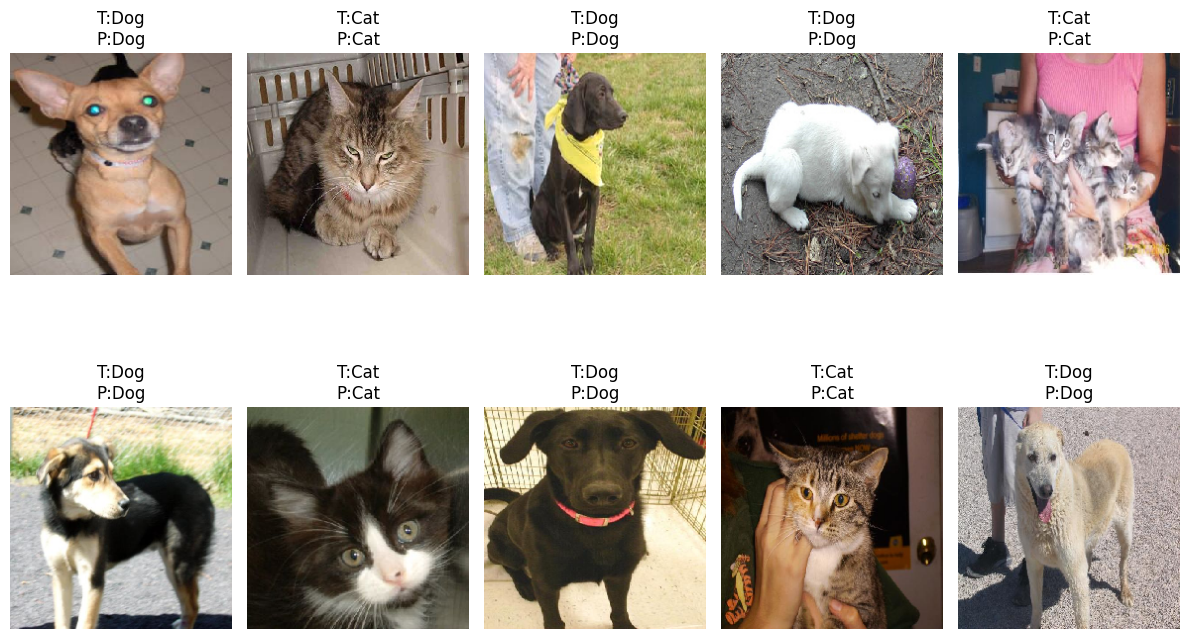

In [8]:
# 10–11. Pilih 10 gambar acak dari data test dan lakukan prediksi

all_test_files = []
for cls in classes:
    all_test_files += glob.glob(os.path.join(TEST_DIR, cls, "*.*"))

# kalau gambar test < 10, pakai semua
if len(all_test_files) >= 10:
    sample_files = random.sample(all_test_files, 10)
else:
    sample_files = all_test_files

plt.figure(figsize=(12,8))
for i, path in enumerate(sample_files):
    img = load_img(path, target_size=IMG_SIZE)
    arr = img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    pred = model.predict(arr)
    pred_idx = np.argmax(pred, axis=1)[0]
    pred_cls = idx_to_class[pred_idx]

    true_cls = os.path.basename(os.path.dirname(path))

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T:{true_cls}\nP:{pred_cls}")

plt.tight_layout()
plt.show()


In [9]:
train_gen.class_indices


{'Cat': 0, 'Dog': 1}